# MBA em Ciência de Dados
### Universidade de São Paulo, São Carlos, Brasil

**Disciplina:** Aprendizado de Máquina

**Professor Reponsavel:** Prof. Dr. André Carlos Ponce de Leon Ferreira de Carvalho
📧 andre@icmc.usp.br
🌐 [linkedin](https://www.linkedin.com/in/andr%C3%A9-carlos-ponce-de-leon-f-de-carvalho-151bb26/)
🔗 [site](http://www.cemeai.icmc.usp.br/component/teamdisplay/108)

# Tutoria - Algoritmos baseados em Proximidade


**Autor:** Eugênio Cabral
📧 eugenio.cabral@alumni.usp.br
🌐 [linkedin](https://www.linkedin.com/in/eug)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,10)})

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_blobs

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp

In [3]:
def as_dataframe(Xy):
    X, y = Xy
    df = pd.DataFrame({f"x{i}": X[:, i] for i in range(X.shape[1])})
    df["class"] = y
    return df

<AxesSubplot:xlabel='x0', ylabel='x1'>

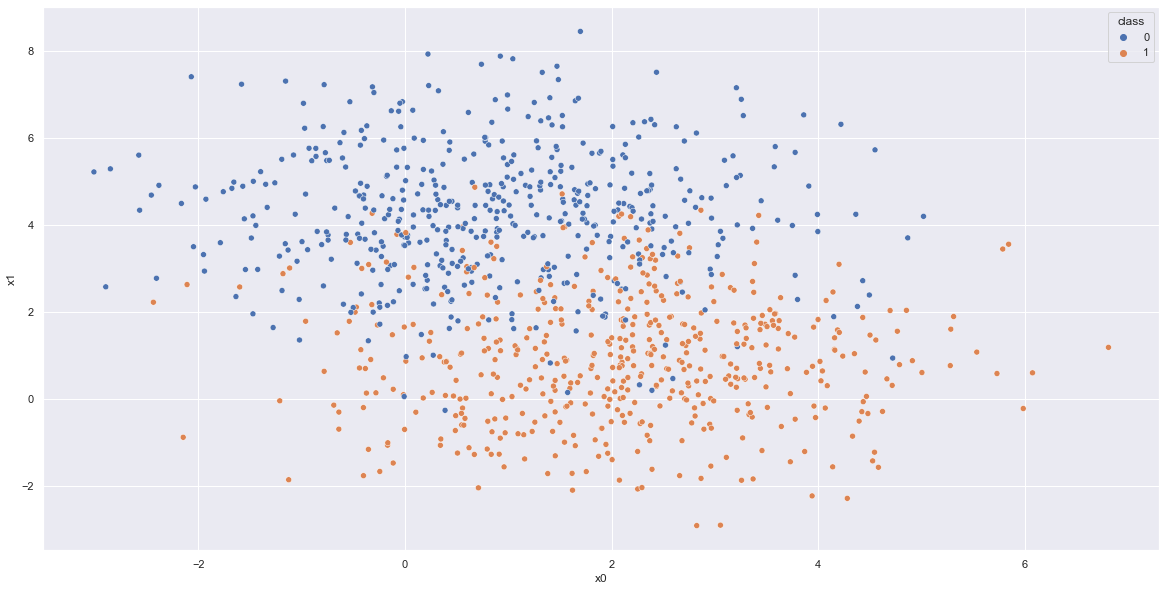

In [4]:
df = as_dataframe(make_blobs(n_samples=1000,
                             centers=2,
                             cluster_std=1.5,
                             n_features=2,
                             random_state=0))

sns.scatterplot(data=df, x="x0", y="x1", hue="class")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="class"), 
                                                    df["class"],
                                                    test_size=0.2,
                                                    random_state=0)

In [6]:
%%time

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
param_metrics = ["euclidean", "cityblock", "manhattan", "cosine"]
param_grid = {
    "knn__n_neighbors": range(1, 10),
    "knn__metric": param_metrics
}

pipe = Pipeline(steps=[("knn", KNeighborsClassifier())])

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
search = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      cv=3,
                      n_jobs=3)

search.fit(X_train, y_train)

Wall time: 1.31 s


GridSearchCV(cv=3, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             n_jobs=3,
             param_grid={'knn__metric': ['euclidean', 'cityblock', 'manhattan',
                                         'cosine'],
                         'knn__n_neighbors': range(1, 10)})

## Visualizando os resultados da busca em grade

In [7]:
result_columns = ["param_knn__metric", "param_knn__n_neighbors", "mean_test_score", "rank_test_score"]
results = pd.DataFrame(search.cv_results_)[result_columns]
results.head()

,param_knn__metric,param_knn__n_neighbors,mean_test_score,rank_test_score
0,euclidean,1,0.830020,32
1,euclidean,2,0.840003,24
2,euclidean,3,0.861240,21
3,euclidean,4,0.873739,16
4,euclidean,5,0.876236,15


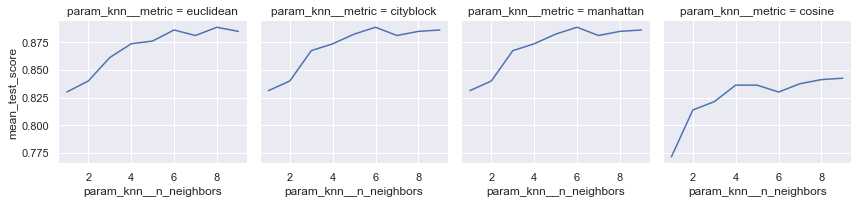

In [8]:
g = sns.FacetGrid(results, col="param_knn__metric")
g.map(sns.lineplot, "param_knn__n_neighbors", "mean_test_score")

In [12]:
search.best_params_

{'knn__metric': 'cityblock', 'knn__n_neighbors': 6}

## Visualizando *bias-variance tradeoff* do KNN

In [9]:
bias = []
variance = []

for _, row in results.iterrows():
    metric = row["param_knn__metric"]
    n_neighbors = row["param_knn__n_neighbors"]
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    model.fit(X_train, y_train)
    
    _, avg_bias, avg_var = bias_variance_decomp(
        model, X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='0-1_loss',
        num_rounds=100,
        random_seed=0)
    bias.append(avg_bias)
    variance.append(avg_var)

results["bias"] = bias
results["variance"] = variance

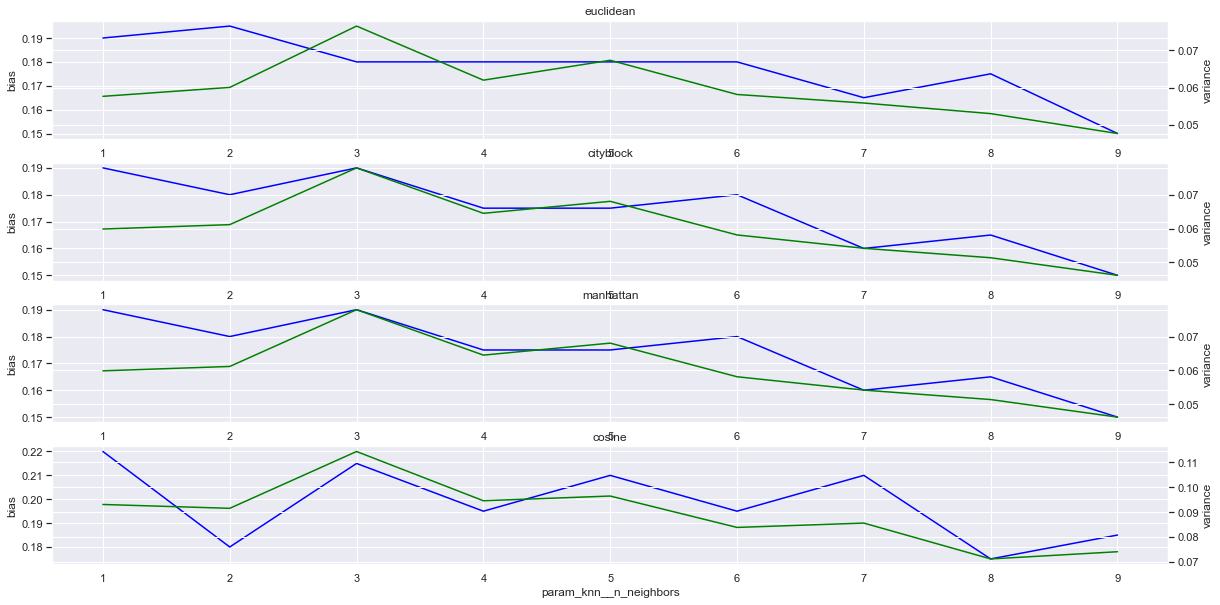

In [10]:
_, axes = plt.subplots(4, 1, figsize=(20, 10))

for ax, metric in zip(axes, param_metrics):
    sns.lineplot(data=results.query(f"param_knn__metric == '{metric}'"), x="param_knn__n_neighbors", y="bias", color="blue", err_style=None, ax=ax)
    sns.lineplot(data=results.query(f"param_knn__metric == '{metric}'"), x="param_knn__n_neighbors", y="variance", color="green", err_style=None, ax=ax.twinx())
    ax.set_title(metric)

<img src="https://miro.medium.com/max/770/1*8sV6Sr9uc0Ef39YBivLzrw.jpeg">

## Visualizando as fronteiras de decisão do modelo com maior score

C:\Users\eucabral\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<AxesSubplot:>

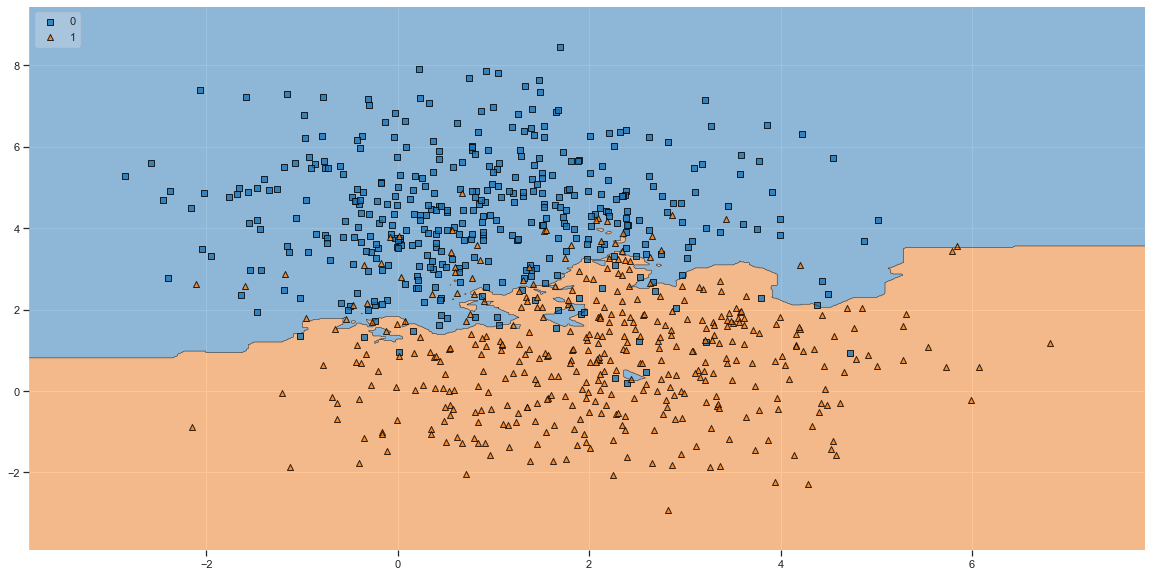

In [11]:
plot_decision_regions(X_train.to_numpy(), 
                      y_train.to_numpy(),
                      clf=search.best_estimator_,
                      legend=2)

## Avaliando no conjunto de teste o melhor modelo com maior score

In [13]:
y_pred = search.best_estimator_.predict(X_test)
print(f"Train Score: {search.best_score_:.2f}", )
print(f"Test Score : {accuracy_score(y_test, y_pred):.2f}")

Train Score: 0.89
Test Score : 0.83


## Visualizando as fronteiras de decisão do modelo com melhor *tradeoff*

In [22]:
model = KNeighborsClassifier(n_neighbors=3, metric="manhattan")
model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

C:\Users\eucabral\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<AxesSubplot:>

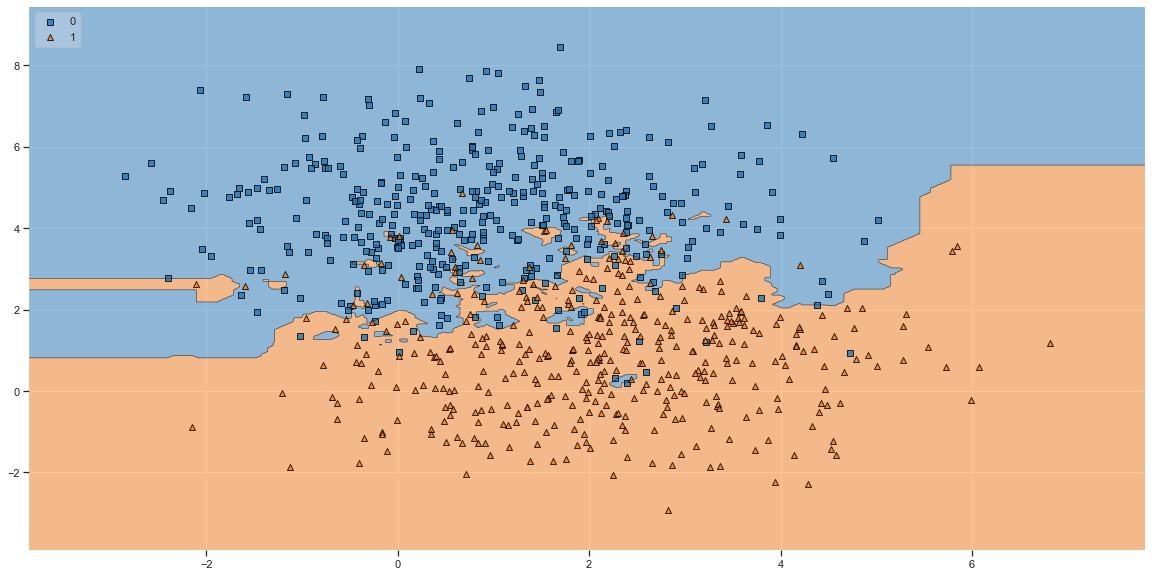

In [23]:
plot_decision_regions(X_train.to_numpy(), 
                      y_train.to_numpy(),
                      clf=model,
                      legend=2)

## Avaliando no conjunto de teste o melhor modelo com melhor *tradeoff* 

In [24]:
y_pred = model.predict(X_test)
print(f"Train Score: {search.best_score_:.2f}", )
print(f"Test Score : {accuracy_score(y_test, y_pred):.2f}")

Train Score: 0.89
Test Score : 0.81


## Referências & Links



1. [Why does increasing k decrease variance in kNN?](https://towardsdatascience.com/why-does-increasing-k-decrease-variance-in-knn-9ed6de2f5061)
2. [kNN and Bias–Variance Tradeoff](https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb)
3. [17 types of similarity and dissimilarity measures](https://towardsdatascience.com/17-types-of-similarity-and-dissimilarity-measures-used-in-data-science-3eb914d2681)
4. [Comparison of the Text Distance Metrics](https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html)
5. [Encyclopedia of Distances](https://link.springer.com/book/10.1007/978-3-642-30958-8)
6. [Comprehensive Survey on Distance](http://www.fisica.edu.uy/~cris/teaching/Cha_pdf_distances_2007.pdf)